In [2]:
import sys
sys.path.append(r'..\scripts')

import numpy as np

## Kernel

### Compute Kernel if not cached

In [3]:
from compute_kernels import parallel_Li, Li

In [4]:
#Define simulation parameters

N = 80 # Number of spatial points
zb, zt = 1, 5 #bounds
k = 2 #wave number
alpha = 4.8
dz = (zt - zb)/N

#Radius function
R = lambda z : 3 - 4.8 * ((z - .5 * (zb + zt))/(zt - zb))**2
R = np.vectorize(R)

if __name__ == '__main__':
    zg, oc, L = parallel_Li(zb, zt, N, k, R, num_workers = None)

In [349]:
np.savez(f'../data_cache/discretizationN={N}_k={k}_R=EandM.npz', zg=zg, oc=oc, L=L)

### Load Cached Kernel

In [64]:
#Define simulation parameters
N = 40 # Number of spatial points
zb, zt = 1, 5 #bounds
k = 2 #wave number|
alpha = 4.8
dz = (zt - zb)/N

#Radius function
R = lambda z : 3 - alpha*((z - 0.5 * (zb + zt))/(zt-zb))**2
R = np.vectorize(R)

discretization = np.load(f'../data_cache/discretizationN={N}_k={k}_R=EandM.npz')
zg, oc, Li = discretization['zg'], discretization['oc'], discretization['L']

## Forward Integration

In [65]:
from steady_state_analysis import compute_eta_decomp, dDelta_dt_from_Delta, inner_product, compute_dDelta_dt_from_range_Delta, generate_contours, build_LDelta
from dynamical_system import F_k, dDelta_dt, deta_dt
from simulation import generate_and_show_plots, simulate
import matplotlib.pyplot as plt

###### Notes
-s_hat = 612, delta_hat = 0.06, kappa = 200, gamma=1

I believe that S_hat = 180, delta_hat = 0.019 (anywhere from 0.014 to 0.019), kappa=5, and gamma= 1 produces 3 steady states (with N = 40). There is a weak wave that increases with height, a strong wave that is baroclinic (decreases away from surface then increases again), and a mix that is unstable. I worry that at 40, we were too coarse to reproduce this. Running the Analysis for a higher N.

In [66]:
def build_param_equivalence(s_hat, delta, Tk, T1, delta_init=None, eta_init=None, layer=None):
    if layer is None:
        layer = T1.shape[0] //2
    if delta_init is None:
        delta_init = np.ones(N) * 0.5
    if eta_init is None:
        eta_init = np.ones(N) * 0.5
    #mult = T1[layer][layer]- Tk[layer][layer]
    mult = (-Tk[layer][layer] + (delta_init/delta_init[layer] * np.abs(eta_init[layer]) * T1[layer]).sum()) * dz
    return s_hat/mult, mult * delta

In [67]:
amplitude = np.random.uniform(0, 0.5)
wavelength = np.random.uniform(1, 20)  # Random wavelength
phase = np.random.uniform(0, 2 * np.pi)  # Random phase
base_wave = amplitude * np.sin(2 * np.pi * zg / wavelength + phase) + 0.5
delta_init = base_wave

amplitude = np.random.uniform(0, 1)
wavelength = np.random.uniform(5, 20)  # Random wavelength
phase = np.random.uniform(0, 2 * np.pi)  # Random phase
base_eta = 0.5 * (1 + np.sin(2 * np.pi * zg / wavelength + phase))
base_eta_imag = 0.5 * (1 + np.cos(2 * np.pi * zg / wavelength + phase))
eta_real_part = (1 - amplitude) * 0.5 + amplitude * base_eta
eta_imaginary_part = (1 - amplitude) * 0.5 + amplitude * base_eta_imag
eta_init = eta_real_part + 1j * eta_imaginary_part

#delta_init = sorted(list(test_continuation[0].solutions), key=lambda x: x.alpha1)[-1].y[:N] 
#eta_init = sorted(list(test_continuation[0].solutions), key=lambda x: x.alpha1)[-1].y[N:2*N] + 1j * sorted(list(test_continuation[0].solutions), key=lambda x: x.alpha1)[-1].y[2*N:3*N]

In [78]:
gamma = 1
S_hat = 200 * 3
delta_hat =0.019 
kappa = 6
Delta_E = np.vectorize(lambda z: 1)


In [7]:
S_hat, delta_hat = build_param_equivalence(20, 0.5, Li, oc)

In [62]:
#delta_init = sorted(test_continuation[0].solutions, key=lambda x: x.alpha1)[19].y[:N] - np.ones(N) * .1
#eta_init = sorted(test_continuation[0].solutions, key=lambda x: x.alpha1)[19].y[N:2*N] + 1j *  sorted(test_continuation[0].solutions, key=lambda x: x.alpha1)[19].y[2*N:3*N]


sol_init = sorted(list(starting_steady_state[0].solutions), key=lambda x: x.alpha1)[1]
delta_init = list(sol_init.y[:N]) - np.ones(N) * 0.3
eta_init = list(sol_init.y[N:2*N] + 1j* sol_init.y[2*N:3*N])
kappa = sol_init.alpha1

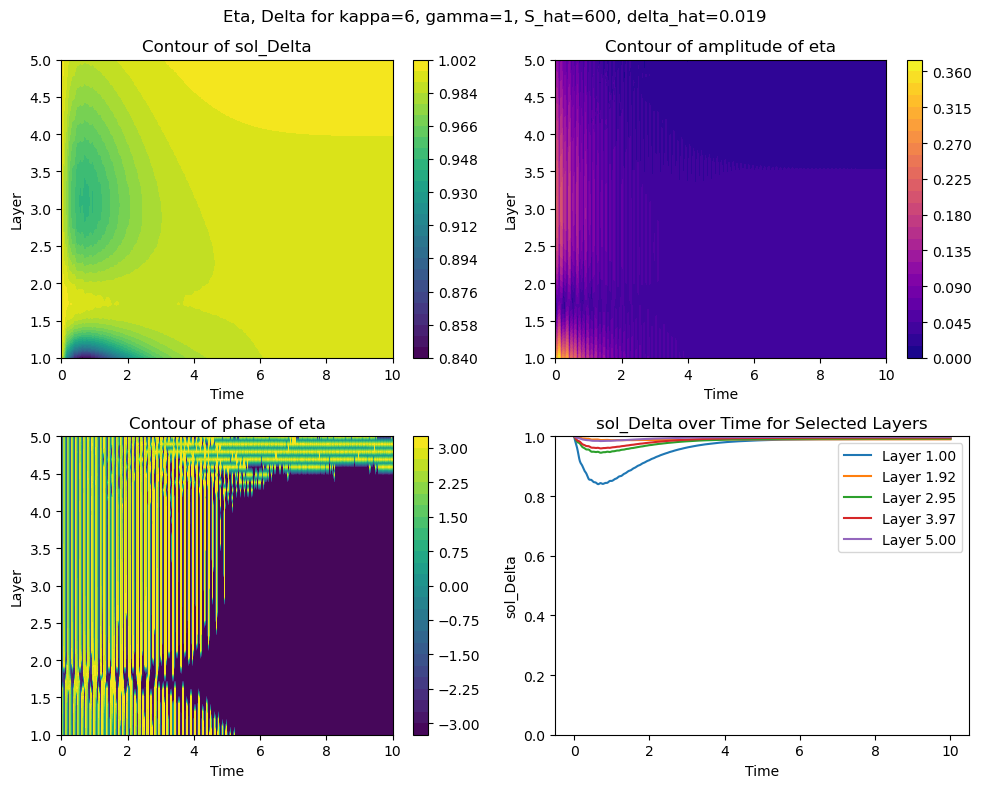

In [79]:
#Load Values
eigenvalues, eigenvectors = np.linalg.eig(build_LDelta(np.ones(N), Li * dz, oc * dz))
Delta0_func = lambda z : 1 #eigenvalues[1] * eigenvectors[:, 1] #
eta0_func =  eigenvectors[:, 1] + 0 * 1j#compute_eta_decomp(Delta0_func, Li, oc, S_hat, delta_hat, F_k, R, zg, k, num_eigenvalues = N)[0] #lambda z : 0 + 0j

generate_plots = True
save = True
read_cache = False
T_final = 10
try: 
    if read_cache:
        steady_states = np.load(f'../data_cache/steady_state_N={N}_S_hat={S_hat}_delta_hat={delta_hat}_kappa={kappa}_gamma={gamma}.npz')
        zg, sol_Delta, sol_eta = steady_states['zg'], steady_states['sol_Delta'], steady_states['sol_eta']
    else:
        raise FileNotFoundError
except FileNotFoundError:
    if generate_plots:
        sol_Delta, sol_eta = generate_and_show_plots(kappa, gamma, S_hat, delta_hat, Delta0_func, eta0_func, Delta_E, R, k, zb, zt, N, T_final, Li, oc, zg, solver='RK45', levels = 30)
    else:
        sol_Delta, sol_eta = simulate(kappa, gamma, S_hat, delta_hat, Delta0_func, eta0_func, Delta_E, R, k, zb, zt, N, T_final, Li, oc, zg, solver='RK45')

    if save:
        np.savez(f'../data_cache/steady_state_N={N}_S_hat={S_hat}_delta_hat={delta_hat}_kappa={kappa}_gamma={gamma}.npz', zg = zg, sol_Delta = sol_Delta, sol_eta = sol_eta)

## Iteration

In [123]:
from steady_state_analysis import compute_eta_decomp, dDelta_dt_from_Delta, inner_product, compute_dDelta_dt_from_range_Delta, generate_contours
from dynamical_system import F_k, dDelta_dt, deta_dt
from simulation import generate_and_show_plots, simulate
import matplotlib.pyplot as plt
from scipy.linalg import eig

In [58]:
iter_sol = sorted(branches[0].solutions, key=lambda x: x.alpha1)[0]

In [59]:
gamma = 1
S_hat = iter_sol.alpha1
delta_hat = 0.06
kappa = 200
Delta_E = np.vectorize(lambda z: 1)

Delta0, _, _ = np.split(iter_sol.y, 3)

In [60]:
#Delta0 =  np.ones(N) * 1
Delta = Delta0
Deltas = [Delta0]
dDeltas = []
etas = []
for i in range(1):
    eta, A_ns, eigenvalues, eigenvectors = compute_eta_decomp(Delta, Li, oc, S_hat, delta_hat, F_k, R, zg, k, num_eigenvalues = N)
    dDelta = dDelta_dt(Delta, eta, Delta_E(zg), gamma, kappa)
    Delta = dDelta + Delta
    dDeltas.append(dDelta)
    Deltas.append(Delta)
    etas.append(eta)
    if np.min(Delta) < 0:
        print('Delta negative, no solution')
        #break
    if np.sum(np.abs(dDelta))/N < 0.001:
        print('dDelta close to 0')
        #break

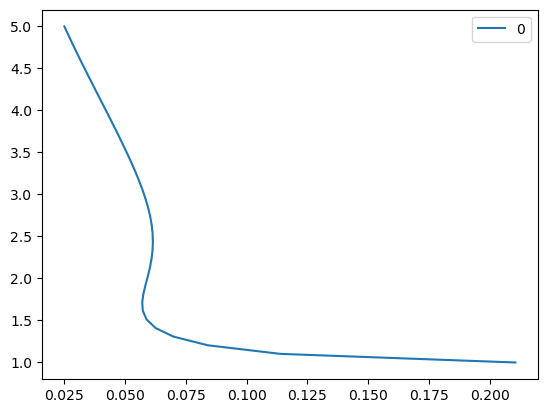

In [61]:
for i, eta in enumerate(etas):
    plt.plot(np.abs(eta), zg, label=str(i))
    plt.legend()

c:\Users\MikeTyrrell\miniconda3\envs\personal\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MikeTyrrell\miniconda3\envs\personal\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


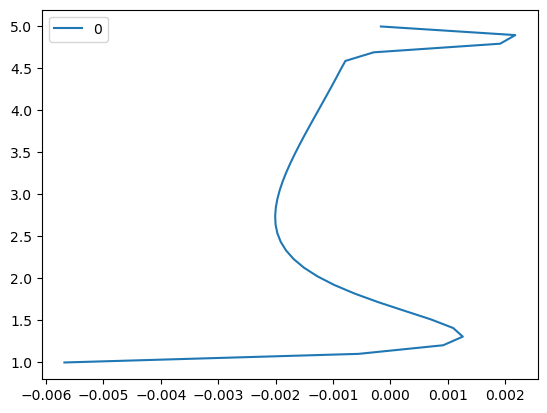

In [62]:
for i, dDelta in enumerate(dDeltas):
    plt.plot(dDelta, zg, label=str(i))
    plt.legend()

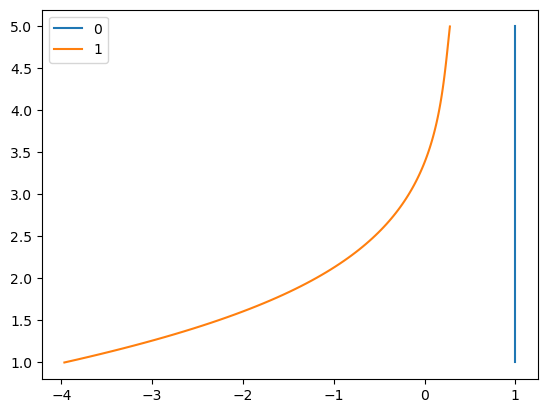

In [128]:
for i, Delta in enumerate(Deltas):
    plt.plot(Delta, zg, label=str(i))
    plt.legend()

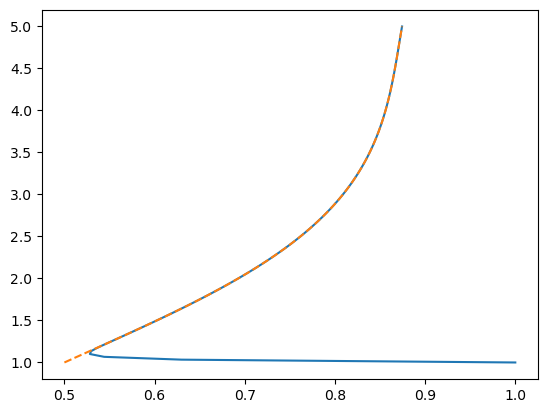

In [116]:
plt.plot(Deltas[-1].real, zg)
plt.plot(1/(1 + (1j* np.vectorize(F_k)(R, zg, k)/max(np.vectorize(F_k)(R, zg, k)))*np.conj(1j * np.vectorize(F_k)(R, zg, k)/max(np.vectorize(F_k)(R, zg, k)))), zg, '--')

In [ ]:
#what is this

z = (zg[1] - zg[0])
L_matrix = Li * dz
omega_c_matrix = np.diag(oc @ np.ones(N) * dz)
base_eigenvalues, base_eigenvectors = np.linalg.eig(L_matrix - omega_c_matrix)
eta_approx = np.zeros(N)
for i in range(N):
    for j in range(N):
        eta_approx += inner_product(np.vectorize(F_k)(R, zg, k), base_eigenvectors[:, i], R, np.ones(N), zg) * inner_product(np.vectorize(F_k)(R, zg, k), base_eigenvectors[:, j], R, np.ones(N), zg) * base_eigenvectors[:, i]*base_eigenvectors[:, j]

## Branch Continuation

In [12]:
from multibranch_param_continuation import Branch, Solution, multiple_branch_continuation_2D, visualize_branches

c:\Users\MikeTyrrell\Python Projects\SSWs\notebooks\..\scripts\multibranch_param_continuation.py:798: SyntaxWarning: invalid escape sequence '\D'
  def visualize_branches(branches, params, parameter='alpha1', parameter_label=None, value_label='mean(\Delta)', stability_stride=5):


In [86]:
Delta_init = np.ones(N) * sol_Delta[:, -1].real
eta_init = sol_eta[:, -1]

## Find all the branches at our solution with an exhaustive search (n_starts = 100)
initial_Delta = Solution(np.concatenate([Delta_init, eta_init.real, eta_init.imag, [kappa, delta_hat]]))
initial_branch = Branch(0, initial_Delta)

Delta_E = np.vectorize(lambda z: 1)(zg)
F_k_vector = np.vectorize(F_k)(R, zg, k)
T_k_integrable = Li * dz
T_1_integrable = oc * dz

params = {'hat_Sk': S_hat, 'kappa': kappa, 'hat_delta': delta_hat, 'gamma': gamma, 'T_k': T_k_integrable, 'T_1': T_1_integrable, 'F_k': F_k_vector, 'Delta_E': Delta_E, 'N': N, 'R': R, 'k': k, 'zg': zg}

In [87]:
starting_steady_state = multiple_branch_continuation_2D(
    [initial_branch],
    0,
    0,
    1,
    params,
    n_starts=100, 
    sweep_range = None,
    tol_new=1e-6,
    solver_tol = 1e-6, 
    search_params=['kappa', 'hat_delta']
)

===== 2D Continuation step 1 =====
[Branch 0] updated => Solution(alpha1=6, alpha2=0.019, mean=0.9931, norm=6.284)
Spawned new Branch 1 with solution Solution(alpha1=6, alpha2=0.019, mean=0.4818, norm=4.523)
Spawned new Branch 2 with solution Solution(alpha1=6, alpha2=0.019, mean=0.4521, norm=5.341)


In [88]:
test_continuation_start = starting_steady_state #np.load(f'../data_cache/potential3soluationsatS_hat={S_hat}kappa={kappa}delta_hat={delta_hat}.npz')['test_continuation']
branches = []
for i, branch in enumerate(test_continuation_start):
    initial_sol = sorted(list(branch.solutions), key=lambda x: x.alpha1)[-1].__copy__()
    branches.append(Branch(i, initial_sol))

In [89]:
#follow these branches with fewer starts (10)
test_continuation = multiple_branch_continuation_2D(
    starting_steady_state,
    0.5,
    0,
    100,
    params,
    n_starts=50, 
    sweep_range = None,
    tol_new=1e-2,
    solver_tol = 1e-4,
    search_params=['kappa', 'hat_delta']
)

===== 2D Continuation step 1 =====
[Branch 1] updated => Solution(alpha1=6.5, alpha2=0.019, mean=0.4837, norm=4.431)
[Branch 0] updated => Solution(alpha1=6.5, alpha2=0.019, mean=0.9925, norm=6.281)
[Branch 2] updated => Solution(alpha1=6.5, alpha2=0.019, mean=0.4511, norm=5.336)
===== 2D Continuation step 2 =====
[Branch 0] updated => Solution(alpha1=7, alpha2=0.019, mean=0.9919, norm=6.277)
[Branch 1] updated => Solution(alpha1=7, alpha2=0.019, mean=0.4855, norm=4.353)
[Branch 2] updated => Solution(alpha1=7, alpha2=0.019, mean=0.45, norm=5.353)
===== 2D Continuation step 3 =====
[Branch 2] updated => Solution(alpha1=7.5, alpha2=0.019, mean=0.4489, norm=5.394)
[Branch 1] updated => Solution(alpha1=7.5, alpha2=0.019, mean=0.4873, norm=4.285)
[Branch 0] updated => Solution(alpha1=7.5, alpha2=0.019, mean=0.9913, norm=6.273)
===== 2D Continuation step 4 =====
[Branch 0] updated => Solution(alpha1=8, alpha2=0.019, mean=0.9907, norm=6.269)
[Branch 2] updated => Solution(alpha1=8, alpha2=0.

In [30]:
def visualize_branches(branches, params, parameter='alpha1', parameter_label=None, value_label='mean(\Delta)', stability_stride=5):
    """
    Visualize the branches by plotting the absolute value of solutions
    against a specified parameter.

    Parameters:
        branches (list): List of Branch objects.
        parameter (str): Parameter to plot on the x-axis ('alpha1' or 'alpha2').
        value_label (str): Label for the y-axis (default: '|Solution|').
    """
    colors = plt.cm.tab10.colors
    plt.figure(figsize=(10, 6))
    for branch in branches:
        # Extract parameter values and absolute solution values for the branch
        param_values = []
        abs_values = []
        stability_flags = []

        sorted_solutions = sorted(branch.solutions, key=lambda s: getattr(s, parameter))

        for idx, sol in enumerate(sorted_solutions):
            if parameter == 'alpha1':
                param_values.append(sol.alpha1)
            elif parameter == 'alpha2':
                param_values.append(sol.alpha2)
            else:
                raise ValueError("Parameter must be 'alpha1' or 'alpha2'")

            abs_values.append(np.split(sol.y, 3)[0].mean())  # Absolute value of the Delta component

            # Stability: compute only every nth point
            if idx % stability_stride == 0:
                is_stable = sol.compute_stability(params)
            stability_flags.append(is_stable)

        param_values = np.array(param_values)
        abs_values = np.array(abs_values)
        stability_flags = np.array(stability_flags)

        # Plot segment-by-segment, using stability flag for linestyle
        for i in range(len(param_values) - 1):
            style = '-' if stability_flags[i] else '--'
            color = colors[branch.branch_id % len(colors)]
            plt.plot(param_values[i:i+2], abs_values[i:i+2], style, color=color)

    plt.xlabel(parameter_label or parameter)
    plt.ylim([.3, 1])
    plt.ylabel(value_label)
    plt.title(f"Branch Visualization ({parameter_label or parameter} vs {value_label}) for N={params['N']}")
    plt.grid()
    plt.tight_layout()
    plt.show()


<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\MikeTyrrell\AppData\Local\Temp\ipykernel_32804\274569123.py:1: SyntaxWarning: invalid escape sequence '\D'
  def visualize_branches(branches, params, parameter='alpha1', parameter_label=None, value_label='mean(\Delta)', stability_stride=5):


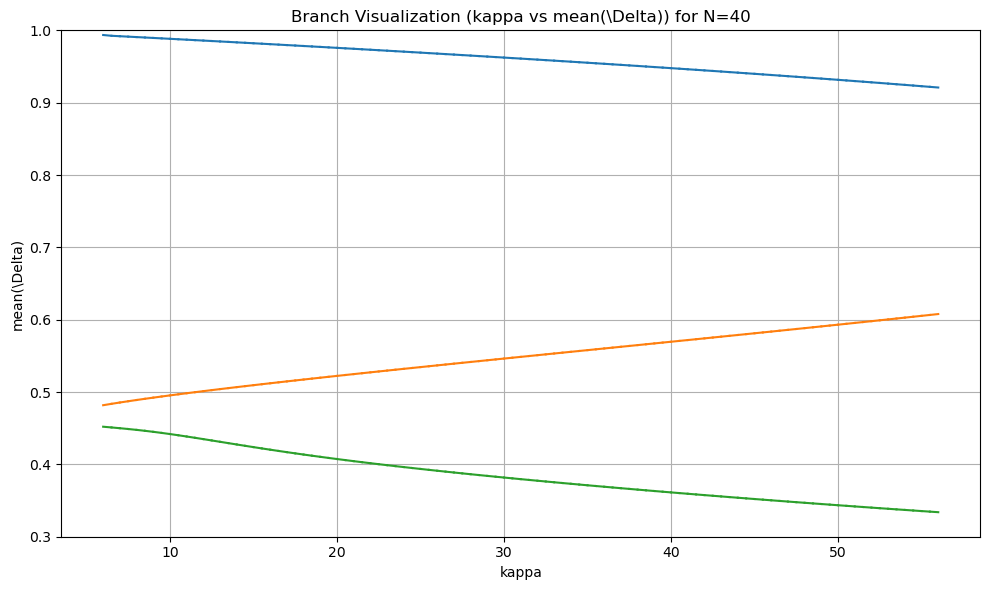

In [90]:
visualize_branches(test_continuation, params, parameter_label='kappa')

In [298]:
#multiple Deltas
#Delta = lambda b: np.exp(1j * b * zg).imag * 0 + b
#b_grid = np.linspace(0, 1, 100)
#vecced_delta = np.array([Delta(b) for b in b_grid])

x_axis_level = N//2
iter_sol = sorted(test_continuation[1].solutions, key=lambda x: x.alpha1)[10]
Delta, _, _ = np.split(iter_sol.y, 3)
b_grid = np.linspace(0, 1 * 1/Delta[x_axis_level], 100)
#b_grid = np.linspace(-1, 1, 100)
vecced_delta = np.array([Delta * b for b in b_grid])
#vecced_delta = np.where(vecced_delta >= 0, vecced_delta, 0)
#vecced_delta = np.where(vecced_delta <= 1, vecced_delta, 1)
kappa = iter_sol.alpha1

dDelta_all, eigenvalues_all, eigenvectors_all =  compute_dDelta_dt_from_range_Delta(vecced_delta, Delta_E, S_hat, delta_hat, gamma, kappa, Li, oc, F_k, R, zg, k, num_eigenvalues = N)

c:\Users\MikeTyrrell\miniconda3\envs\personal\Lib\site-packages\matplotlib\contour.py:1515: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
c:\Users\MikeTyrrell\miniconda3\envs\personal\Lib\site-packages\matplotlib\contour.py:1516: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
c:\Users\MikeTyrrell\miniconda3\envs\personal\Lib\site-packages\matplotlib\contour.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg, np.float64)
c:\Users\MikeTyrrell\miniconda3\envs\personal\Lib\site-packages\numpy\ma\core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


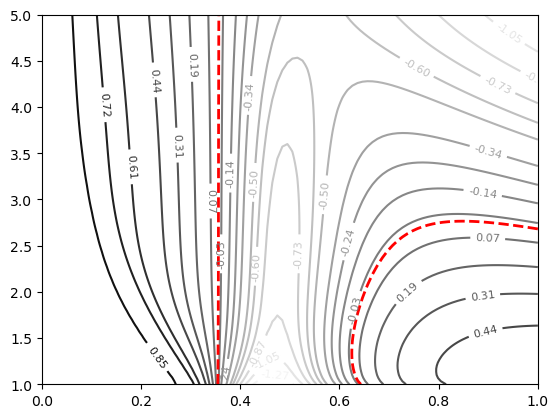

In [299]:
generate_contours(dDelta_all, np.array(vecced_delta), zg, x_axis_level, min_spacing = .1)

In [94]:
np.savez(f'../data_cache/branchesS_hat={S_hat}delta_hat={delta_hat}kappa_1={kappa}kappa_2={kappa + 50}.npz', test_continuation=test_continuation)

In [ ]:
np.savez(f'../data_cache/potential3soluationsatS_hat={S_hat}kappa={kappa}delta_hat={delta_hat}.npz', test_continuation=test_continuation)

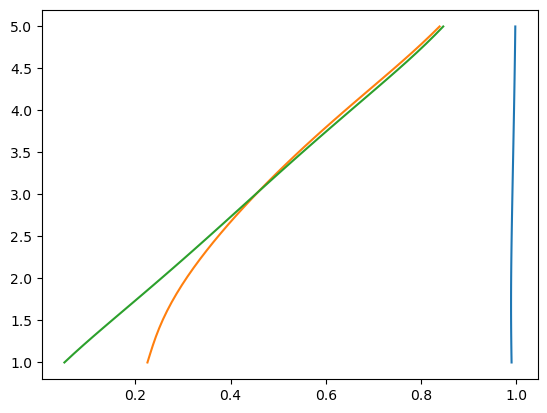

In [93]:
ordered_sol = sorted(list(test_continuation[0].solutions), key=lambda x: x.alpha1)
ordered_sol_2 = sorted(list(test_continuation[1].solutions), key=lambda x: x.alpha1)
ordered_sol_3 = sorted(list(test_continuation[2].solutions), key=lambda x: x.alpha1)

plt.plot(np.split(ordered_sol[0].y, 3)[0], zg)
plt.plot(np.split(ordered_sol_2[0].y, 3)[0], zg)
plt.plot(np.split(ordered_sol_3[0].y, 3)[0], zg)
#plt.plot(sol_Delta[:, -1], zg)

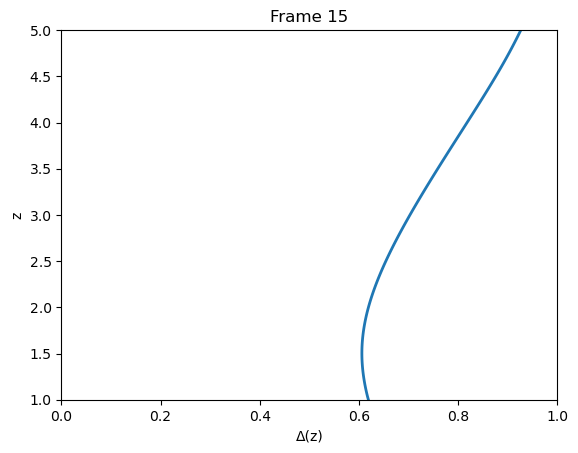

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Setup figure
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 1)  # Adjust this range based on your delta values
ax.set_ylim(min(zg), max(zg))  # zg must be defined
ax.set_xlabel("Δ(z)")
ax.set_ylabel("z")
title = ax.set_title("")

def init():
    line.set_data([], [])
    return line,

def update(i):
    y_split = np.split(ordered_sol_3[i].y, 3)
    delta = y_split[0]
    line.set_data(delta, zg)
    title.set_text(f"Frame {i}")
    return line, title

ani = FuncAnimation(fig, update, frames=len(ordered_sol_3),
                    init_func=init, blit=True, interval=200)

# Display in HTML (for Jupyter)
html_anim = HTML(ani.to_jshtml())
display(html_anim)


# Archive

## Bifurcation Searching

### Search for multiple soluutions

In [6]:
from steady_state_analysis import optimization_wrapper, compute_eta_decomp
from dynamical_system import F_k, dDelta_dt

In [7]:
#gamma = 1
#S_hat = 1
#delta_hat = 0.085
#kappa = 5
Delta_E = np.vectorize(lambda z: 1)(zg)

Delta0 = sol_Delta[:, -1] #np.ones(N)

F_k_vector = np.vectorize(F_k)(R, zg, k)

init_params = np.concatenate([Delta0, [S_hat, delta_hat, kappa]])

In [ ]:
res, null_space = optimization_wrapper(init_params, Li, oc, F_k_vector, R, zg, k, Delta_E, num_eigenvalues=None)

In [ ]:
eta, _, eigenvalues, eigenvectors = compute_eta_decomp(res.x[:-3], Li, oc, S_hat, delta_hat, 
                                          F_k_vector, R, zg, 
                                          k)

dDelta = dDelta_dt(res.x[:-3], eta, Delta_E, 1, kappa)

eigenvalues

### Other

In [10]:
from steady_state_analysis import parameter_continuation_with_bifurcations, plot_continuation_results, \
    parameter_continuation_with_bifurcations_2d, plot_continuation_results_2d, parameter_continuation_with_bifurcation_full, \
parameter_continuation_with_bifurcation_full_2d, parameter_continuation_with_bifurcation_coefficients_space, plot_continuation_results_2d_coefs
from dynamical_system import F_k
import matplotlib.pyplot as plt

In [7]:
Delta_E = np.vectorize(lambda z: 1)(zg)
Delta_init = np.ones(N) * sol_Delta[:, -1].real
eta_init = sol_eta[:, -1]
F_k_vector = np.vectorize(F_k)(R, zg, k)
T_k_integrable = Li * dz
T_1_integrable = oc * dz

In [8]:
params = {'hat_Sk': 200, 'kappa': 10, 'hat_delta': 0.05, 'gamma': 1, 'T_k': T_k_integrable, 'T_1': T_1_integrable, 'F_k': F_k_vector, 'Delta_E': Delta_E}
S_hat_vals = np.logspace(np.log10(0.1), np.log10(500),50)
delta_hat_vals = np.logspace(np.log10(0.001), np.log10(0.8), 80)
kappa_vals = np.linspace(1, 50, 50)


### Decoupled

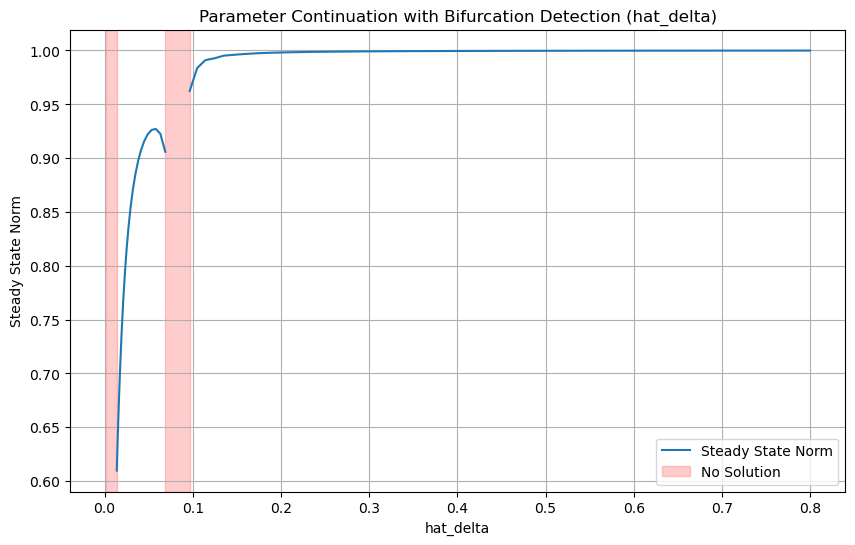

In [24]:
bifurcation_map = parameter_continuation_with_bifurcations(Delta_init, params, 'hat_delta', delta_hat_vals, T_k_integrable, T_1_integrable, F_k_vector, Delta_E, tol=1e-8)
plot_continuation_results(delta_hat_vals, bifurcation_map, 'hat_delta')

In [61]:
bifurcation_map_2d = parameter_continuation_with_bifurcations_2d(Delta_init, params, 'kappa', kappa_vals, 'hat_Sk', S_hat_vals, T_k_integrable, T_1_integrable, F_k_vector, Delta_E, tol=1e-8)

c:\Users\MikeTyrrell\Python Projects\SSWs\notebooks\..\scripts\steady_state_analysis.py:639: ComplexWarning: Casting complex values to real discards the imaginary part
  J[:, i] = (R_perturbed - R) / epsilon


c:\Users\MikeTyrrell\Python Projects\SSWs\notebooks\..\scripts\steady_state_analysis.py:846: ComplexWarning: Casting complex values to real discards the imaginary part
  steady_state_norms[i, j] = np.mean(Delta_sol)


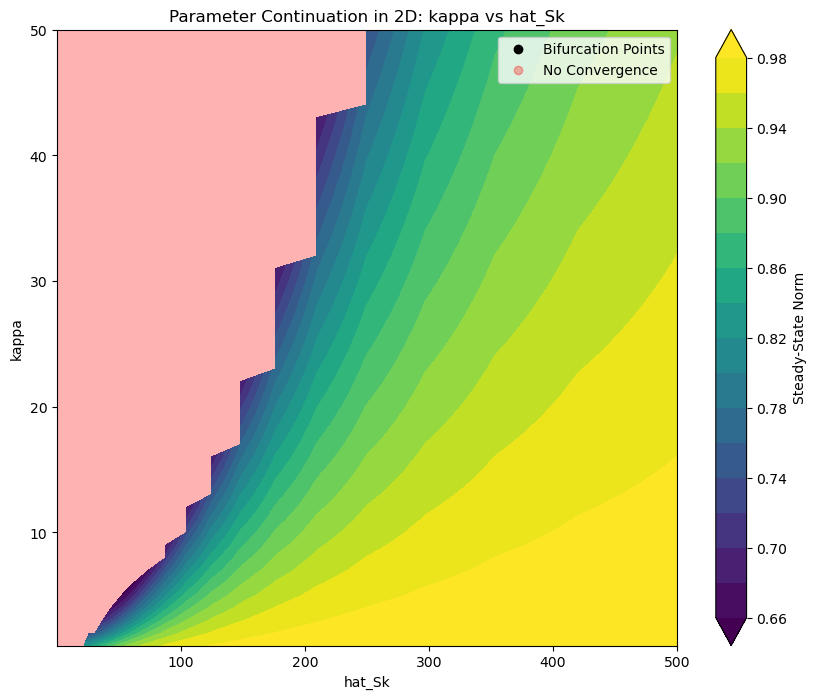

In [62]:
plot_continuation_results_2d(kappa_vals, S_hat_vals, bifurcation_map_2d, 'kappa', 'hat_Sk')

### Coupled

In [ ]:
bifurcation_map = parameter_continuation_with_bifurcation_full(np.concatenate([Delta_init, eta_init.real, eta_init.imag]), params, 'hat_delta', (0, 0.8), step_size=0.01)

param_vals = [param_val[0] for param_val in bifurcation_map]
Delta_vals = [param_val[1][:N] if param_val[1] is not None else None for param_val in bifurcation_map]

Delta_only_bifucation_map = [(param_vals[i], Delta_vals[i], bifurcation_map[i][2]) for i in range(len(bifurcation_map))]

plot_continuation_results(param_vals, Delta_only_bifucation_map, 'hat_delta')

In [31]:
bifurcation_map_2d = parameter_continuation_with_bifurcation_full_2d(np.concatenate([Delta_init, eta_init.real, eta_init.imag]), params, 'hat_delta', (0, 0.4), 0.01, 'hat_Sk', (1, 500), 20, tolerance=1e-8)

Continuation failed at (0.01, 101): The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Continuation failed at (0.02, 61): The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Continuation failed at (0.03, 41): The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Continuation failed at (0.03, 81): The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Continuation failed at (0.04, 61): The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Continuation failed at (0.05, 81): The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Continuation failed at (0.05, 181): The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evalua

In [32]:
param_1_vals = np.sort(list(set([param[0] for param in bifurcation_map_2d.keys()])))
param_2_vals = np.sort(list(set([param[1] for param in bifurcation_map_2d.keys()])))

bifurcation_map_2d_Delta = {
    (param1, param2): (solution[:N], bool1, bool2) if solution is not None else (None, bool1, bool2)
    for (param1, param2), (solution, bool1, bool2) in bifurcation_map_2d.items()
}


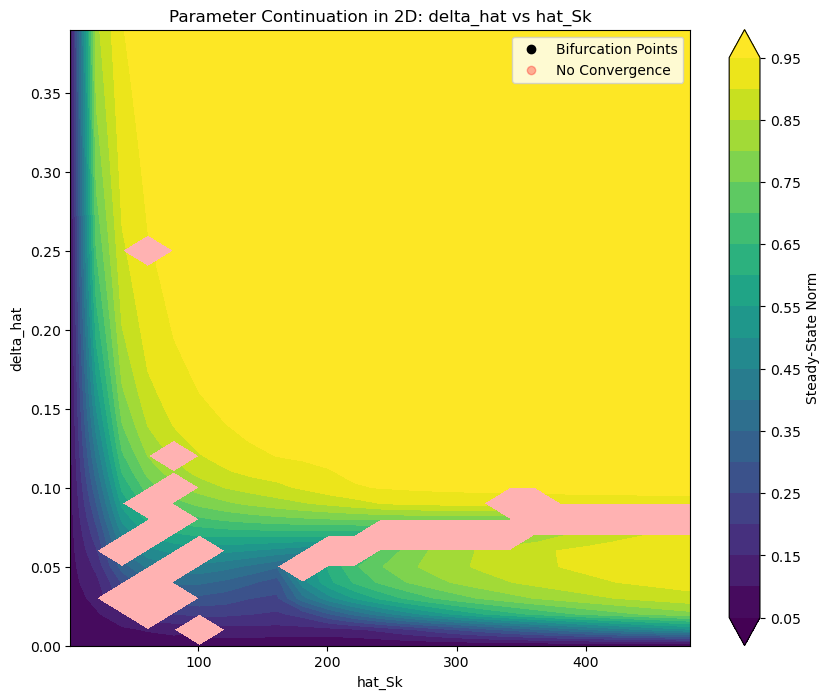

In [33]:
plot_continuation_results_2d(param_1_vals, param_2_vals, bifurcation_map_2d_Delta, 'delta_hat', 'hat_Sk')

### Eigenfunction Expansion

In [9]:
bifurcation_map_eigenfunctions =  parameter_continuation_with_bifurcation_coefficients_space(np.concatenate([Delta_init, eta_init]), params, 'hat_delta', (0, 0.4), 0.05, 'hat_Sk', (1, 100), 20, np.vectorize(R)(zg), zg, tolerance=1e-8)

c:\Users\MikeTyrrell\Python Projects\SSWs\notebooks\..\scripts\dynamical_system.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  eta.real = eta_real
c:\Users\MikeTyrrell\Python Projects\SSWs\notebooks\..\scripts\dynamical_system.py:160: ComplexWarning: Casting complex values to real discards the imaginary part
  eta.imag = eta_imag


Continuation failed at (0.15000000000000002, 81): The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Continuation failed at (0.2, 61): The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Continuation failed at (0.2, 81): The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.


In [13]:
param_1_vals = np.sort(list(set([param[0] for param in bifurcation_map_eigenfunctions.keys()])))
param_2_vals = np.sort(list(set([param[1] for param in bifurcation_map_eigenfunctions.keys()])))

bifurcation_map_2d_eig_Delta = {
    (param1, param2): (solution[:N], bool1, bool2) if solution is not None else (None, bool1, bool2)
    for (param1, param2), (solution, bool1, bool2) in bifurcation_map_eigenfunctions.items()
}


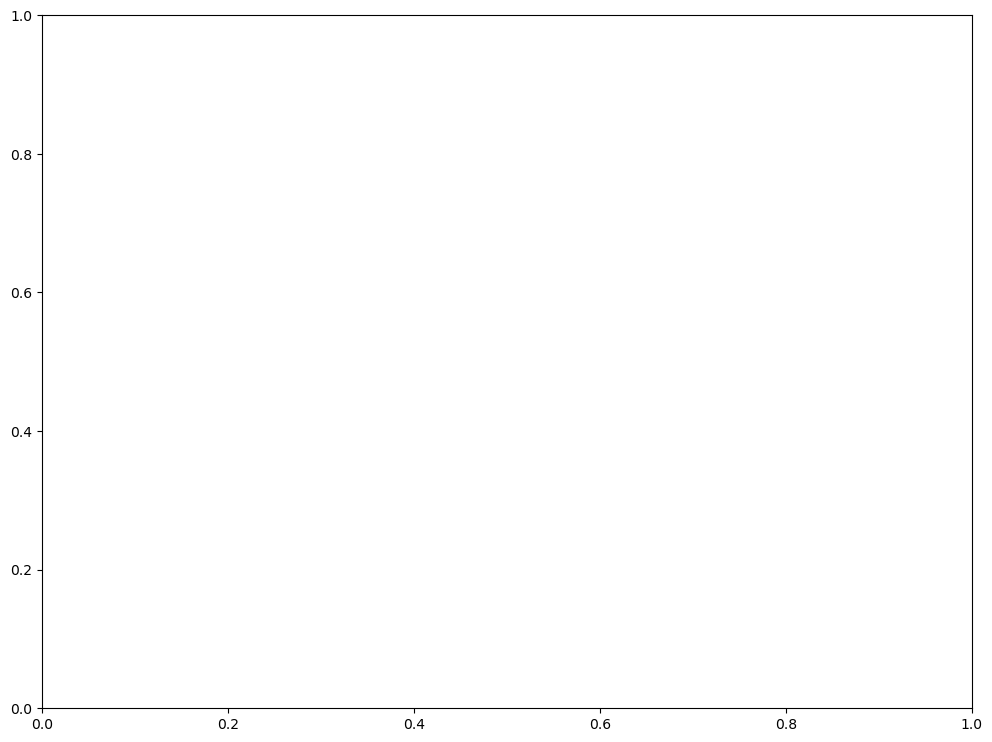

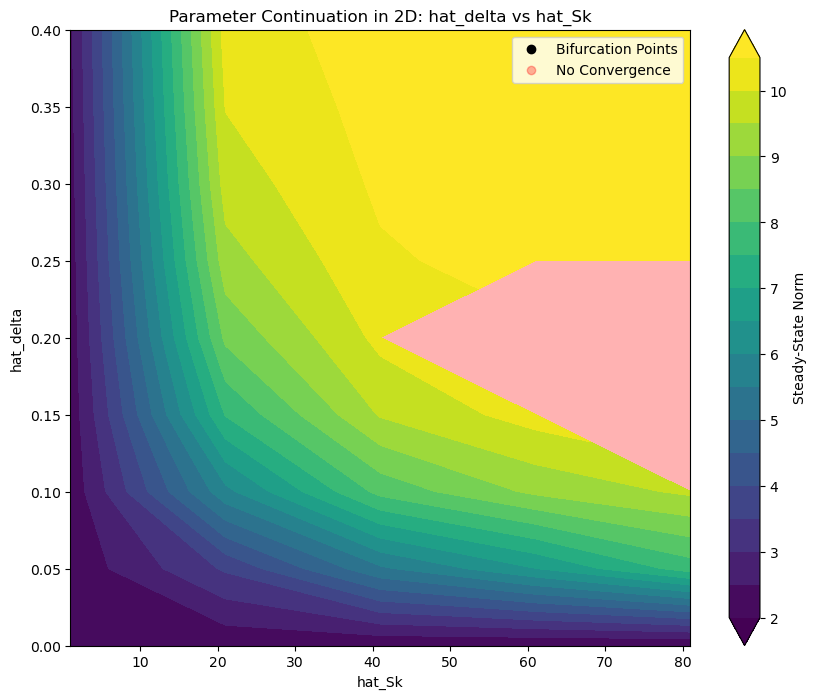

In [37]:
plot_continuation_results_2d_coefs(param_1_vals, param_2_vals, bifurcation_map_2d_eig_Delta, 'hat_delta', 'hat_Sk', eigenfunc_indices = [0])

## Compute Steady States Old

In [ ]:
from steady_state_analysis import compute_adomian_decomp_terms, pseudo_arclength_continutation, compute_steady_state
from simulation import simulate
from dynamical_system import F_k
import matplotlib.pyplot as plt

### Pseudo-Arclength

In [ ]:
#Default Parameters
T_final = 300
gamma = 0.1
S_hat = 100
delta_hat = 0.1
kappa = 30
Delta0_func = lambda z : 1
eta0_func = lambda z : 1 + 0j
Delta_E = np.vectorize(lambda z : 0.5)

sol_T, sol_Delta, sol_eta = simulate(kappa, gamma, S_hat, delta_hat, Delta0_func, eta0_func, Delta_E, R, k, zb, zt, N, T_final, Li, oc, solver='BDF')

In [ ]:
#Initial guess for state variable is 
z0 = np.concatenate([sol_Delta[:, -1], sol_eta[:, -1]]) # Initial guess for state variables
lambda0 = np.array([100])  # Initial guess for parameter vector (3 components)
zlambd0 = np.concatenate([z0, lambda0])

# Parameters for continuation
s0 = 0.0  # Initial arclength
ds = 2  # Arclength increment
num_steps = 100  # Number of continuation steps

dz = (zt - zb)/N

function_params = (L, oc, Delta_E(zg), F_k(R, zg, k)) #gamma, L, oc, DeltaE, Fk, N, dz 

# Perform continuation
results, convergence = pseudo_arclength_continuation(zlambd0, function_params, N, dz, ds, S_hat = S_hat, delta_hat = delta_hat, kappa = kappa, gamma=gamma, max_steps=num_steps, jac_epislon=1e-8)

np.savez(f'SteadyStatesVaringKappaPseudoArc.npz', results = results, convergence=convergence) 

results


## Visual Investigation

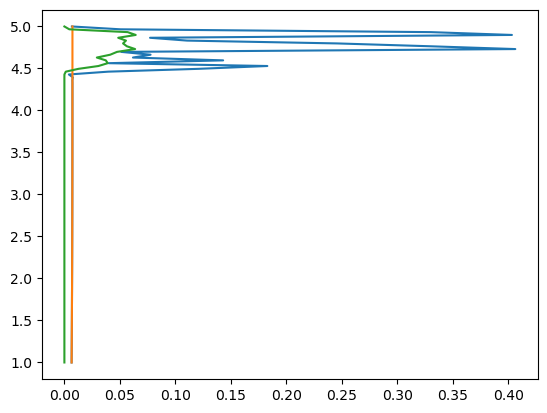

In [ ]:
#compute single \eta 
Delta = sol_Delta[:, -1]
#Delta = vecced_delta[95]
eta, A_ns, eigenvalues, eigenvectors = compute_eta_decomp(Delta, Li, oc, S_hat, delta_hat, F_k, R, zg, k, num_eigenvalues = N)

plt.plot(np.abs(sol_eta[:, -1]), zg)
plt.plot(np.abs(eta), zg)

plt.plot(dDelta_dt_from_Delta(Delta, Delta_E, S_hat, delta_hat, gamma, kappa, Li, oc, F_k, R, zg, k, num_eigenvalues = N)[0], zg)

In [ ]:
delta_hat = 0.01

In [ ]:
#Compute resonant eigenvalue
neg_resonant_value = -delta_hat - np.sqrt(delta_hat - delta_hat**2 - S_hat**(-2))
pos_resonant_value = -delta_hat + np.sqrt(delta_hat - delta_hat**2 - S_hat**(-2))

print(-np.min(oc @ Delta * dz))

print(pos_resonant_value)

print(neg_resonant_value)

np.argmin(np.abs(eigenvalues - neg_resonant_value))

-0.15071069897441416
0.0894987437106615
-0.10949874371066148


In [ ]:
#multiple Deltas
#Delta = lambda b: np.exp(1j * b * zg).imag * 0 + b
#b_grid = np.linspace(0, 1, 100)
#vecced_delta = np.array([Delta(b) for b in b_grid])

x_axis_level = N//2
Delta = sol_Delta[:, -1]
b_grid = np.linspace(0, 1/Delta[x_axis_level], 100)
#b_grid = np.linspace(-1, 1, 100)
vecced_delta = np.array([Delta * b for b in b_grid])
#vecced_delta = np.where(vecced_delta >= 0, vecced_delta, 0)
#vecced_delta = np.where(vecced_delta <= 1, vecced_delta, 1)

dDelta_all, eigenvalues_all, eigenvectors_all =  compute_dDelta_dt_from_range_Delta(vecced_delta, Delta_E, S_hat, delta_hat, gamma, kappa, Li, oc, F_k, R, zg, k, num_eigenvalues = N)

c:\Users\MikeTyrrell\Python Projects\SSWs\notebooks\..\scripts\steady_state_analysis.py:261: RuntimeWarning: divide by zero encountered in divide
  eigenvectors[:, i] /= norm  # Normalize the eigenvector
c:\Users\MikeTyrrell\Python Projects\SSWs\notebooks\..\scripts\steady_state_analysis.py:261: RuntimeWarning: invalid value encountered in divide
  eigenvectors[:, i] /= norm  # Normalize the eigenvector
c:\Users\MikeTyrrell\Python Projects\SSWs\notebooks\..\scripts\steady_state_analysis.py:213: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.exp(-zg) * R**2 * Delta * f * np.conj(g) * dz)


In [ ]:
Delta = np.ones(N)
L_matrix = Li * Delta * dz
omega_c_matrix = np.diag(oc @ Delta * dz)
base_eigenvalues, base_eigenvectors = np.linalg.eig(L_matrix - omega_c_matrix)

In [ ]:
Delta_sigmoid = lambda b: 1/(1 + np.exp(-b * zg)) 
Delta_sin = lambda b: np.exp(1j * b * zg).imag 
b_grid = np.linspace(0, 1, 10)
vecced_delta = np.concatenate([[np.ones(N)], np.array([Delta_sigmoid(b) for b in b_grid]), np.array([Delta_sin(b) for b in b_grid])])

eigenvalues_list = []
eigenvectors_list = []
spectrum_boundary = []
for i in range(vecced_delta.shape[0]):
    Delta = vecced_delta[i]
    L_matrix = Li * Delta * dz
    omega_c_matrix = np.diag(oc @ Delta * dz)
    eigenvalues, eigenvectors = np.linalg.eig(L_matrix - omega_c_matrix)
    eigenvalues_list.append(eigenvalues)
    eigenvectors_list.append(eigenvectors)
    spectrum_boundary.append(np.min(oc @ Delta * dz))

eigenvalues_arr = np.array(eigenvalues_list)
eigenvectors_arr = np.array(eigenvectors_list)
spectrum_boundary = np.array(spectrum_boundary)

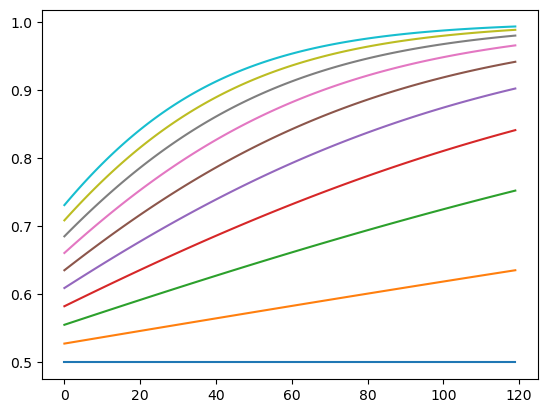

In [ ]:
for b in b_grid:
    plt.plot(Delta_sigmoid(b))

In [ ]:
np.sign(eigenvectors_arr[0, 0, 2].real)

1.0

c:\Users\MikeTyrrell\miniconda3\envs\'personal'\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MikeTyrrell\miniconda3\envs\'personal'\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


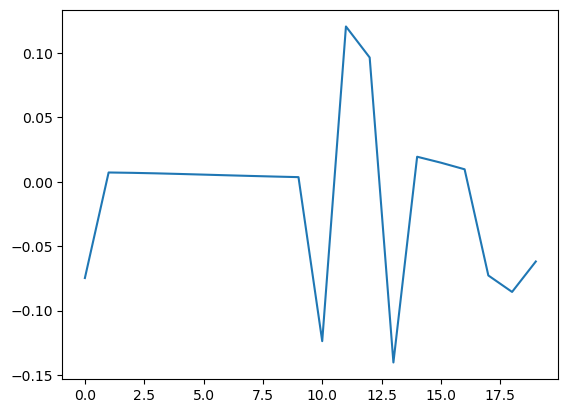

In [ ]:
plt.plot([eigenvalues_arr[i-1, 4] - eigenvalues_arr[i, 4] for i in range(1, len(vecced_delta))])

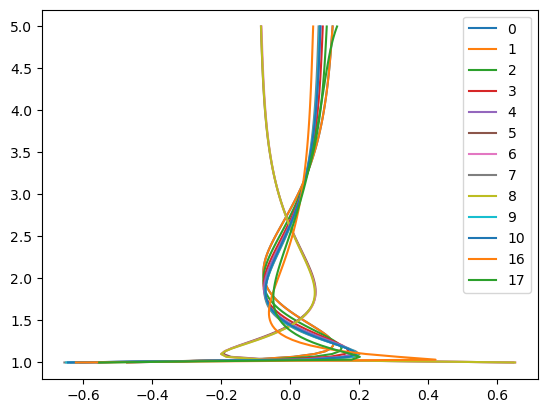

In [ ]:
eigenvector_to_plot = 3
for i in range(len(vecced_delta)):
    discrete = -eigenvalues_arr[i, eigenvector_to_plot] < spectrum_boundary[i]
    if (discrete or (i == 0)):
        plt.plot(eigenvectors_arr[i, :, eigenvector_to_plot].real, zg, label=str(i))
    plt.legend()

c:\Users\MikeTyrrell\miniconda3\envs\'personal'\Lib\site-packages\matplotlib\contour.py:1531: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.asarray(x, dtype=np.float64)
c:\Users\MikeTyrrell\miniconda3\envs\'personal'\Lib\site-packages\matplotlib\contour.py:1515: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
c:\Users\MikeTyrrell\miniconda3\envs\'personal'\Lib\site-packages\matplotlib\contour.py:1516: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
c:\Users\MikeTyrrell\miniconda3\envs\'personal'\Lib\site-packages\matplotlib\contour.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg, np.float64)
c:\Users\MikeTyrrell\miniconda3\envs\'personal'\Lib\site-packages\numpy\ma\core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part

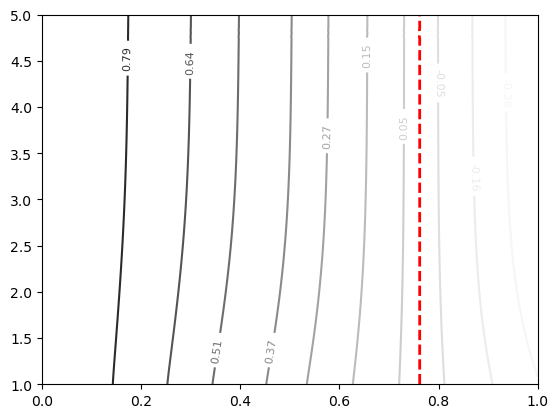

In [ ]:
generate_contours(dDelta_all, np.array(vecced_delta), zg, x_axis_level, min_spacing = .1)

In [ ]:
# Flatten the sliced array and get indices of the smallest 5 values
arr = np.abs(eigenvalues - delta_hat - 1/S_hat)
flat_indices = np.argsort(arr, axis=None)[:10]

# Convert the flat indices back to coordinates in the original array
top_min_indices = [np.unravel_index(idx, arr.shape) for idx in flat_indices]

# Adjust indices to account for the slice
#top_min_indices = [(i + 0, j + 0) for i, j in top_min_indices]

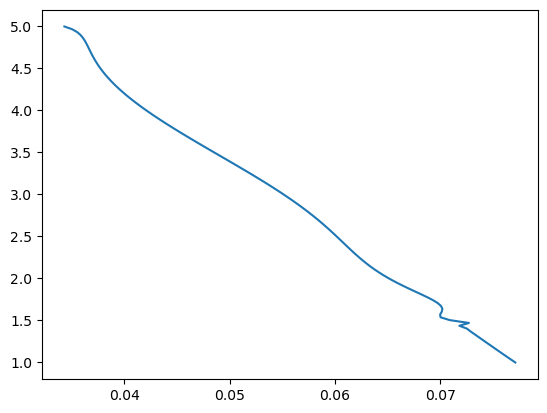

In [ ]:
plt.plot(np.abs(np.sum(-A_ns[top_min_indices] * eigenvectors[:, top_min_indices], axis=1)), zg)

In [ ]:
np.abs(eigenvalues_all[63] - delta_hat - 1/S_hat).argmin()

0

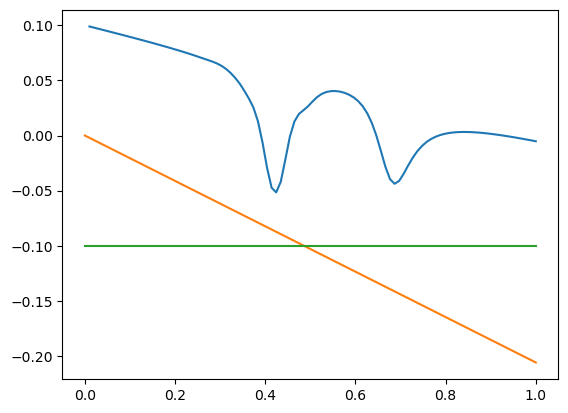

In [ ]:
plt.plot(vecced_delta[:, N//2], dDelta_all[:, N//2])
plt.plot(vecced_delta[:, N//2], eigenvalues_all[:, 1])
plt.plot(vecced_delta[:, N//2], np.ones(100) * -delta_hat)

In [ ]:
def compute_interaction(eigenvalue_1, eigenvalue_2):
    #return ((eigenvalue_1 + delta_hat) - 1/(1j * S_hat)) * np.conj((eigenvalue_2 + delta_hat) - 1/(1j * S_hat))
    return (eigenvalue_1 + delta_hat) * (eigenvalue_2 + delta_hat) + 1/(S_hat)**2 - 1j/S_hat*(eigenvalue_2 + delta_hat) + 1j/S_hat*(eigenvalue_1 + delta_hat) #these interaction terms actually cancel since we have double but with eigenvealues flipped, if this makes sense

In [ ]:
Fk = np.vectorize(F_k)(R, zg, k)
def one_term(arr_idx, idx_1, idx_2):
    eigenvalue_1 = eigenvalues_all[arr_idx][idx_1]
    eigenvalue_2 = eigenvalues_all[arr_idx][idx_2]
    eigenvector_1= eigenvectors_all[arr_idx][:, idx_1]
    eigenvector_2 = eigenvectors_all[arr_idx][:, idx_2]
    inner_prod = inner_product(1j * Fk, eigenvector_1, R, vecced_delta[arr_idx], zg) * np.conj(inner_product(1j * Fk, eigenvector_2, R, vecced_delta[arr_idx], zg))
    A_n_term = -inner_prod/(compute_interaction(eigenvalue_1, eigenvalue_2))
    return A_n_term * eigenvector_1 * np.conj(eigenvector_2)

In [ ]:
interactions = np.ones((eigenvalues_all.shape[1], eigenvalues_all.shape[1]), dtype=np.complex128) * np.nan
for i, eigenvalue_1 in enumerate(eigenvalues_all[95]):
    for j, eigenvalue_2 in enumerate(eigenvalues_all[95]):
        interactions[i, j] = compute_interaction(eigenvalue_1, eigenvalue_2)

In [ ]:
sub_array = interactions

# Flatten the sliced array and get indices of the smallest 5 values
flat_indices = np.argsort(sub_array, axis=None)[:1]

# Convert the flat indices back to coordinates in the original array
top_min_indices = [np.unravel_index(idx, sub_array.shape) for idx in flat_indices]

# Adjust indices to account for the slice
#top_min_indices = [(i + 0, j + 0) for i, j in top_min_indices]

In [ ]:
contributing_terms = [one_term(95, i, j) for (i, j) in top_min_indices]

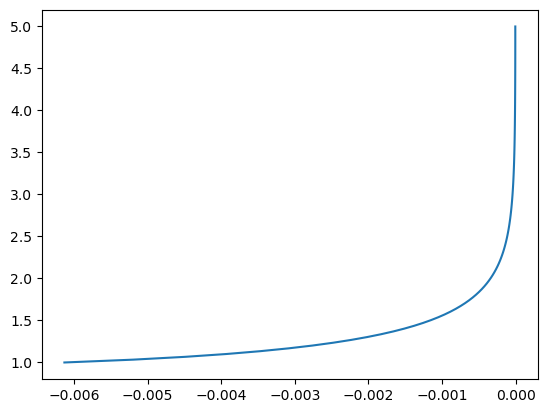

In [ ]:
plt.plot(np.sum(contributing_terms, axis=0)/S_hat**2, zg)

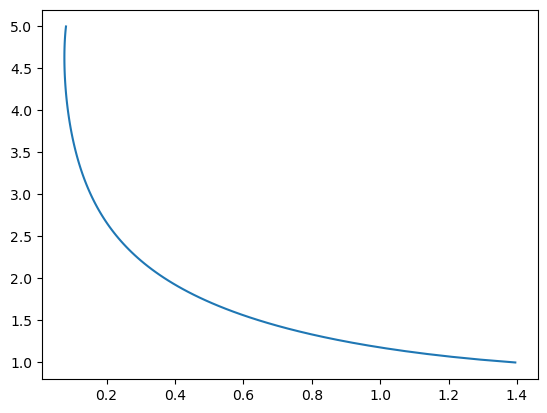

In [ ]:
plt.plot(np.abs(eta), zg)

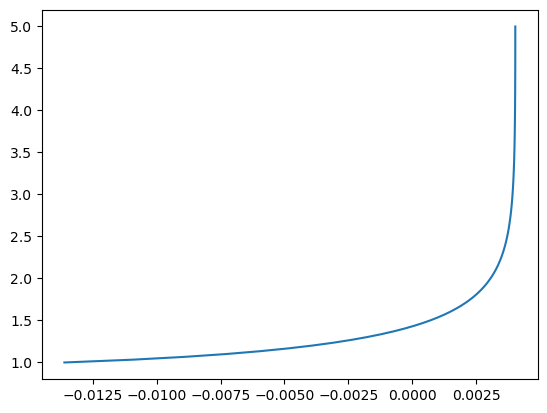

In [ ]:
plt.plot(gamma * (Delta_E/np.max(Delta_E) - vecced_delta[95] - vecced_delta[95] * kappa/S_hat**2 * np.sum(contributing_terms, axis=0)), zg)

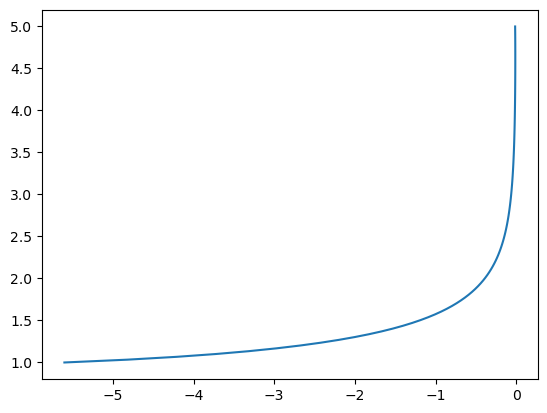

In [ ]:
plt.plot(dDelta_all[95], zg)

In [ ]:
dDelta_all = np.array([result[0] for result in res]) 

dDelta_projections = []
Delta_projections =[]
for i, result in enumerate(res):
    dDelta = result[0]
    eigenvalue = result[1]
    eigenvectors = result[2]
    #dDelta_projections.append(inner_product(dDelta, eigenvectors[:, 1], R, vecced_delta[i], zg))
    #Delta_projections.append(inner_product(vecced_delta[i], eigenvectors[:, 1], R, vecced_delta[i], zg))
    dDelta_projections.append(dDelta[N//2])
    Delta_projections.append(vecced_delta[i, N//2])


In [ ]:
zero_coords = []
for path in zero_contour.collections[0].get_paths():
    vertices = path.vertices
    zero_coords.append(vertices)

C:\Users\MikeTyrrell\AppData\Local\Temp\ipykernel_40340\702686078.py:2: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for path in zero_contour.collections[0].get_paths():


In [ ]:
Delta_at_0 = np.array([(delta, z_val) for delta, z_val in zip(zero_coords[0][:, 0], zg)])[:, 0]

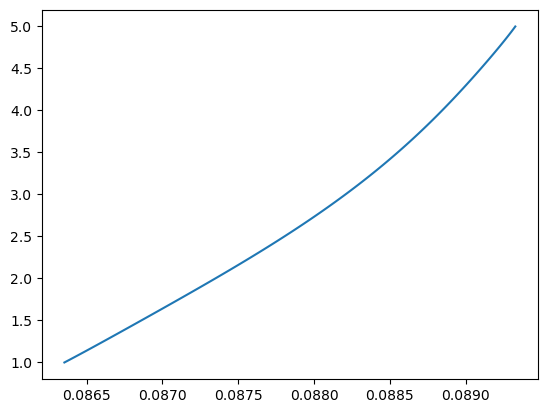

In [ ]:
plt.plot(dDelta_all[10, :], zg)